## Model na predikciu DST za pomoci použitia atribútu DST, BZ_GSM a KP o 6 hodín dopredu

Súbor: predikcia_DST+6.ipynb

Program: Hospodárska informatika

Vypracovala: Terézia Drengubiaková

Bakalárska práca: : Prediktívne modely v spracovaní dát z oblasti kozmického počasia

Vedúci diplomovej práce: doc. Ing. Peter Butka, PhD.

Konzultanti: Ing. Viera Krešňáková, PhD., RNDr. Šimon Mackovjak, PhD.

### Import knižníc

In [1]:
import pandas as pd
import numpy as np
from tensorflow import keras
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()
import seaborn as sns
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Input, Conv1D, LSTM, MaxPooling1D, Flatten, TimeDistributed, Bidirectional
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.models import Model
from scipy.special import expit, logit
from sklearn.metrics import confusion_matrix, classification_report, matthews_corrcoef

2024-05-20 20:36:41.418227: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Načítanie dát, odstránenie na hodnôt, určenie predikovaného atribútu

In [2]:
train = pd.read_csv('train_omni.csv')
test = pd.read_csv('test_omni.csv')
train['BZ_GSM'] = train['BZ_GSM'].fillna(train['BZ_GSM'].mean())  # Naplní NaN hodnoty priemerom danej stĺpca
test['BZ_GSM'] = test['BZ_GSM'].fillna(test['BZ_GSM'].mean()) 
features = ['time1', 'DST', 'DST+6', 'BZ_GSM']
test = test[features]
train = train[features]
train['time1']=pd.to_datetime(train['time1'])
test['time1']=pd.to_datetime(test['time1'])
predicators = ["DST", "BZ_GSM"]
y_col='DST+6'
valid_size = int(len(train) * 0.2)
valid = train.iloc[-valid_size:,:].copy()
train = train.iloc[:-valid_size,:].copy()

y_train = train[y_col].values.copy()
X_train = train[predicators].values.copy()
y_val = valid[y_col].values.copy()
X_val = valid[predicators].values.copy()
y_test = test[y_col].values.copy()
X_test = test[predicators].values.copy()

### Definícia premenných a vytvorenie dátových generátorov

In [3]:
n_input = 6  
n_features= len(X_train)  
b_size = 256  

train_generator = TimeseriesGenerator(X_train, y_train, length=n_input, batch_size=b_size)
val_generator = TimeseriesGenerator(X_val, y_val, length=n_input, batch_size=b_size)
test_generator = TimeseriesGenerator(X_test, y_test, length=n_input, batch_size=256)

In [4]:
print("Počet batchov: ", len(train_generator))
print("Každý batch má features (X zložku) a labels (y zložku): ", len(train_generator[0]))
print("Dĺžka X zložky batchu: ", len(train_generator[0][0]))
print("Dĺžka y zložky batchu (počet meraní v batchi): ",len(train_generator[0][1]))
print("Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu): ", len(train_generator[0][0][0]))

Počet batchov:  896
Každý batch má features (X zložku) a labels (y zložku):  2
Dĺžka X zložky batchu:  256
Dĺžka y zložky batchu (počet meraní v batchi):  256
Počet riadkov braných do úvahy pre jedno meranie (koľko sa pozerá dozadu):  6


### Vytvorenie modelu

In [5]:
inputs = Input(shape=(6,2))
c = Bidirectional(LSTM(128, return_sequences=True, dropout=0.1,recurrent_dropout=0.1))(inputs)
c = LSTM(128, return_sequences=True)(c)
c = TimeDistributed(Dense(1, activation='linear'))(c)
output = Flatten()(c)
output = Dense(1, activation='linear')(output)
model = Model(inputs=inputs, outputs=output)
model.compile(loss='mse', optimizer='adam', metrics=["mae"])
print(model.summary())

2024-05-20 20:36:49.799714: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 6, 2)]            0         
                                                                 
 bidirectional (Bidirectiona  (None, 6, 256)           134144    
 l)                                                              
                                                                 
 lstm_1 (LSTM)               (None, 6, 128)            197120    
                                                                 
 time_distributed (TimeDistr  (None, 6, 1)             129       
 ibuted)                                                         
                                                                 
 flatten (Flatten)           (None, 6)                 0         
                                                                 
 dense_1 (Dense)             (None, 1)                 7     

In [6]:
saved_model = "6h_dopredu200+BZ.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor='val_mae', verbose=1, save_best_only=True, mode='min')
early = EarlyStopping(monitor="val_mae", mode="min", patience=25)
callbacks_list = [checkpoint, early]

### Trénovanie

In [7]:
history = model.fit(train_generator, validation_data=val_generator, epochs=200, verbose=1, callbacks = callbacks_list)

Epoch 1/200
896/896 [==============================] - ETA: 0s - loss: 217.3116 - mae: 8.8821
Epoch 1: val_mae improved from inf to 9.88426, saving model to 6h_dopredu200+BZ.hdf5
896/896 [==============================] - 64s 65ms/step - loss: 217.3116 - mae: 8.8821 - val_loss: 307.0596 - val_mae: 9.8843
Epoch 2/200
896/896 [==============================] - ETA: 0s - loss: 161.0509 - mae: 7.9460
Epoch 2: val_mae improved from 9.88426 to 9.39469, saving model to 6h_dopredu200+BZ.hdf5
896/896 [==============================] - 55s 61ms/step - loss: 161.0509 - mae: 7.9460 - val_loss: 258.5621 - val_mae: 9.3947
Epoch 3/200
895/896 [============================>.] - ETA: 0s - loss: 154.5922 - mae: 7.8644
Epoch 3: val_mae did not improve from 9.39469
896/896 [==============================] - 56s 62ms/step - loss: 154.5271 - mae: 7.8645 - val_loss: 272.2454 - val_mae: 9.7512
Epoch 4/200
896/896 [==============================] - ETA: 0s - loss: 150.4288 - mae: 7.8056
Epoch 4: val_mae improv

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



896/896 [==============================] - ETA: 0s - loss: 135.9597 - mae: 7.5178
Epoch 18: val_mae did not improve from 9.16343
896/896 [==============================] - 56s 62ms/step - loss: 135.9597 - mae: 7.5178 - val_loss: 246.7505 - val_mae: 9.3379
Epoch 19/200
895/896 [============================>.] - ETA: 0s - loss: 136.6041 - mae: 7.5176
Epoch 19: val_mae improved from 9.16343 to 9.00667, saving model to 6h_dopredu200+BZ.hdf5
896/896 [==============================] - 56s 62ms/step - loss: 136.5779 - mae: 7.5174 - val_loss: 219.8609 - val_mae: 9.0067
Epoch 20/200
 60/896 [=>............................] - ETA: 47s - loss: 145.7846 - mae: 7.8010

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



895/896 [============================>.] - ETA: 0s - loss: 135.0685 - mae: 7.4947
Epoch 21: val_mae did not improve from 9.00667
896/896 [==============================] - 56s 62ms/step - loss: 134.9844 - mae: 7.4929 - val_loss: 282.0108 - val_mae: 10.1914
Epoch 22/200
896/896 [==============================] - ETA: 0s - loss: 134.8512 - mae: 7.4906
Epoch 22: val_mae did not improve from 9.00667
896/896 [==============================] - 56s 63ms/step - loss: 134.8512 - mae: 7.4906 - val_loss: 259.8038 - val_mae: 9.5931
Epoch 23/200
896/896 [==============================] - ETA: 0s - loss: 134.3882 - mae: 7.4795
Epoch 23: val_mae did not improve from 9.00667
896/896 [==============================] - 56s 62ms/step - loss: 134.3882 - mae: 7.4795 - val_loss: 240.1309 - val_mae: 9.3316
Epoch 24/200
256/896 [=======>......................] - ETA: 36s - loss: 128.2042 - mae: 7.4845

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



896/896 [==============================] - ETA: 0s - loss: 129.7088 - mae: 7.4135
Epoch 34: val_mae did not improve from 9.00667
896/896 [==============================] - 56s 63ms/step - loss: 129.7088 - mae: 7.4135 - val_loss: 237.5754 - val_mae: 9.2878
Epoch 35/200
742/896 [=======================>......] - ETA: 8s - loss: 126.3858 - mae: 7.3900

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



896/896 [==============================] - ETA: 0s - loss: 128.6562 - mae: 7.4038
Epoch 37: val_mae did not improve from 9.00667
896/896 [==============================] - 56s 62ms/step - loss: 128.6562 - mae: 7.4038 - val_loss: 242.3991 - val_mae: 9.3834
Epoch 38/200
896/896 [==============================] - ETA: 0s - loss: 128.9164 - mae: 7.4000
Epoch 38: val_mae did not improve from 9.00667
896/896 [==============================] - 56s 63ms/step - loss: 128.9164 - mae: 7.4000 - val_loss: 236.9121 - val_mae: 9.1403
Epoch 39/200
896/896 [==============================] - ETA: 0s - loss: 128.9316 - mae: 7.4048
Epoch 39: val_mae did not improve from 9.00667
896/896 [==============================] - 57s 63ms/step - loss: 128.9316 - mae: 7.4048 - val_loss: 265.0014 - val_mae: 9.8384
Epoch 40/200
119/896 [==>...........................] - ETA: 44s - loss: 127.6853 - mae: 7.5133

IOPub message rate exceeded.
The Jupyter server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--ServerApp.iopub_msg_rate_limit`.

Current values:
ServerApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
ServerApp.rate_limit_window=3.0 (secs)



### Načítanie najlepšieho modelu

In [8]:
model = keras.models.load_model('6h_dopredu200+BZ.hdf5')

### Vytvorenie predikcií

In [9]:
y_pred = model.predict(test_generator)

633/633 [==============================] - 16s 23ms/step


### Nájdenie optimálneho thresholdu na validačnej sade

In [11]:
y_val_pred = model.predict(val_generator)

true_labels_val = np.where(y_val[n_input:] <= -20, 1, 0) 

def calculate_mcc(y_true, y_pred):
    return matthews_corrcoef(y_true, y_pred)

thresholds = np.arange(-10, -40, -0.1)
mcc_scores = []

for thresh in thresholds:
    predictions = np.where(y_val_pred <= thresh, 1, 0)
    mcc = calculate_mcc(true_labels_val, predictions)
    mcc_scores.append(mcc)

best_threshold_mcc = thresholds[np.argmax(mcc_scores)]
best_mcc = max(mcc_scores)

print("Best Threshold for MCC on Validation Set:", best_threshold_mcc)
print("Best MCC on Validation Set:", best_mcc)
best_threshold_mcc_rounded = round(best_threshold_mcc, 1)


224/224 [==============================] - 5s 23ms/step
Best Threshold for MCC on Validation Set: -17.699999999999974
Best MCC on Validation Set: 0.7237730795194612


### Výpočet metrík, vykreslenie grafu predikcie a uloženie predikcií

In [10]:
from sklearn.metrics import mean_squared_error
y_test2 = y_test[:-6]
mse = mean_squared_error(y_test2, y_pred.reshape(-1))
print(f"Mean Squared Error: {mse}")

Mean Squared Error: 33.82734936513145


In [12]:
y_pred2 = np.where(y_pred <= best_threshold_mcc_rounded, 1, 0)
y_test2 = np.where(y_test[n_input:]  <= -20, 1, 0)

cm = confusion_matrix(y_test2, y_pred2)
print("Confusion matrix: \n" + str(cm))

Confusion matrix: 
[[123535   6454]
 [  9853  22188]]


In [13]:
print(classification_report(y_test2, y_pred2))


              precision    recall  f1-score   support

           0       0.93      0.95      0.94    129989
           1       0.77      0.69      0.73     32041

    accuracy                           0.90    162030
   macro avg       0.85      0.82      0.83    162030
weighted avg       0.90      0.90      0.90    162030



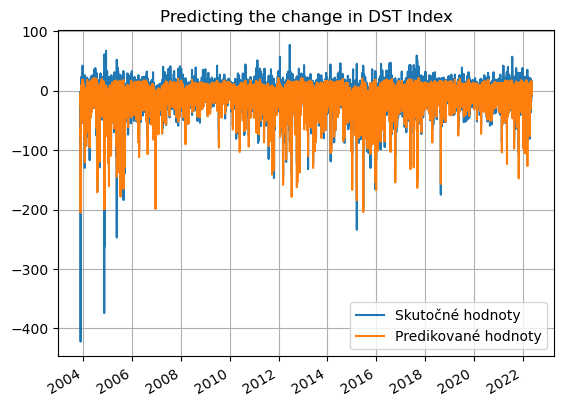

In [14]:
df = pd.DataFrame(data={"time": test['time1'][n_input:],"y_true": y_test[n_input:].reshape(-1) , "y_predict": y_pred.reshape(-1)})

plt.figure()
plt.title('Predicting the change in DST Index')
plt.plot(df['time'],df['y_true'], label='Skutočné hodnoty')
plt.plot(df['time'],df['y_predict'], label='Predikované hodnoty')
plt.legend()
plt.gcf().autofmt_xdate()
plt.grid(True)

In [15]:
df.to_csv('6h_dopredu+200+BZ.csv')

In [16]:
TN, FP, FN, TP = cm.ravel()
ACC = (TP + TN) / (TP + TN + FP + FN)
MCC = matthews_corrcoef(y_test2, y_pred2)
print("ACC={}".format(ACC))
print("MCC={}".format(MCC))

ACC=0.899358143553663
MCC=0.6711929934551714
